  *Mark Isken* 
  (2020-04-15)
  
  The material in this notebook is provided under the [MIT License](https://opensource.org/licenses/MIT).

# Resource modeling in CHIME - Part 2 of n
## A prototype stochastic census model

In [Part 1](https://github.com/misken/c19/blob/master/mychime/modeling/chime_flow_resources_p1.ipynb) of this CHIME resource modeling series, the goal was to:

> try to help people (including myself) better understand the concepts, math and code behind the resource modeling in [CHIME](https://github.com/CodeForPhilly/chime).

In this notebook I want to explore possibilities for using queueing model based approximations for the census projections in CHIME. My primary reasons are:

* current census model is a deterministic, discrete time, "fluid flow" type model and I wonder about the impact of ignoring stochastic effects in length of stay and in number of admits per day.
* a stochastic model offers the possibility of presenting projected census distribution information for each day instead of one fixed point forecast. Percentiles are extremely important in capacity planning.
* I've spent a good part of my career building stochastic models, both queueing based and discrete event simulations, for healthcare systems and I've seen the value they can bring.

This approach is different, but I'd say complementary, to efforts to directly model input parameter uncertainty in some sort of Bayesian framework. In this approach, we are treating the projected admits as an estimate of the underlying arrival rate function in a time-dependent stochastic process. Specifically, we are modeling arrivals with a [non-homogeneous Poisson process](https://en.wikipedia.org/wiki/Poisson_point_process) (NHPP), a widely accepted approach to modeling time-dependent arrivals to queueing systems subject to, essentially, random arrivals. Then we model the system of hospital arrivals and subsequent stay in the hospital as a $M_t/G/\infty$ queueing system (i.e. Markovian arrivals, general service time distribution, infinite number of servers). There's a a handy result that census in such a system is Poisson distributed at each time point, $t$, with mean value function, $m(t)$, where $m(t)$ is a relatively simple function (an integral) of the arrival rate function $\lambda(t)$ and the stationary excess (residual) distribution of the service time (length of stay in our case) random variable. By obtaining $m(t)$, it is easy then to compute percentiles of census using the Poisson distribution directly (for smallish census values) or the normal approximation to the Poisson for moderate to large census values.

All the key details of $M_t/G/\infty$ systems can be found in the following two references and sources within:

* [Eick, 1993] Eick, Stephen G., William A. Massey, and Ward Whitt. "The physics of the Mt/G/∞ queue." Operations Research 41, no. 4 (1993): 731-742.
* [Eick, 1993b] Eick, Stephen G., William A. Massey, and Ward Whitt. "Mt/G/∞ queues with sinusoidal arrival rates." Management Science 39, no. 2 (1993): 241-252.

**Note:** This notebook was created on 2020-04-14 based on CHIME code as of that date.

In [136]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [137]:
from scipy.optimize import curve_fit
from scipy.stats import expon
from scipy.stats import poisson
from scipy.stats import norm
from scipy.stats import gamma
from functools import partial
from scipy.integrate import quad

In [138]:
%matplotlib inline

## Simulate a base scenario

I'll use parameters consistent with v1.1.3 of CHIME and run the model using the `sim_chime_scenario_runner` wrapper I developed which calls the CHIME model. In addition providing the standard CHIME output dataframes, the `runner` wrapper returns long and wide formatted dataframes which consolidate admit and census columns and can optionally include actual admit and census values by date from our system. These long and wide form dataframes make the plotting and modeling I do here a little easier.

Here are a set of [CHIME input values](https://code-for-philly.gitbook.io/chime/what-is-chime/parameters) for the current model.

%load data/semi_0408b.cfg

    --population 5026226
    --market-share 0.32
    --current-hospitalized 1059
    --date-first-hospitalized 2020-02-20
    --mitigation-date 2020-03-21
    --current-date 2020-04-08
    --relative-contact-rate 0.55
    --hospitalized-rate 0.025
    --icu-rate 0.0075
    --ventilated-rate 0.005
    --infectious-days 10
    --hospitalized-day 7
    --icu-days 9
    --ventilated-day 10
    --n-days 120
    --recovered 0






Let's run the CHIME model for this scenario.

In [139]:
# Import the scenario runner. It will import various penn_chime artifacts.
import sim_chime_scenario_runner as runner

In [140]:
# This scenario name string will get prepended to all output files
scenario = 'semi_0408'
config_file = 'data/semi_0408.cfg'
actual_file = 'data/semi_actual_0408.csv'

# Create a penn_chime Parameters object
p = runner.create_params_from_file(config_file) 

# Run the model
model, results = runner.sim_chime(scenario, p) 

# Add the actual values
results = runner.include_actual(results, actual_file)

2020-04-15 13:48:39,183 - penn_chime.model.parameters - INFO - Using file: data/semi_0408.cfg
2020-04-15 13:48:39,185 - penn_chime.model.sir - INFO - Using date_first_hospitalized: 2020-02-20; current_date: 2020-04-08; i_day: 48, current_hospitalized: 1059
2020-04-15 13:48:39,257 - penn_chime.model.sir - INFO - Estimated doubling_time: 3.26780508121616
2020-04-15 13:48:39,262 - penn_chime.model.sir - INFO - len(np.arange(-i_day, n_days+1)): 169
2020-04-15 13:48:39,263 - penn_chime.model.sir - INFO - len(raw_df): 169


As a reminder, here are the keys in the `results` dictionary. My `sim_chime_scenario_runner.sim_chime()` function just:

- packages up the various dataframes that CHIME creates, 
- adds wide and long versions to facilitate plotting and other analysis,
- adds a few dictionaries of variable values into a container dictionary for output processing convenience.

In [141]:
results.keys()

dict_keys(['result_type', 'scenario', 'input_params_dict', 'important_variables_dict', 'sim_sir_w_date_df', 'dispositions_df', 'admits_df', 'census_df', 'adm_cen_wide_df', 'adm_cen_long_df'])

This notebook will mostly be using `adm_cen_wide_df`, `adm_cen_long_df` and the `input_params_dict`. So, let's pull them out into variables to save some typing.

In [142]:
adm_cen_wide_df = results['adm_cen_wide_df']
adm_cen_long_df = results['adm_cen_long_df']
inputs = results['input_params_dict']

Let's take a look at each.

In [143]:
adm_cen_wide_df.head(10)

,day,date,admits_hospitalized,admits_icu,admits_ventilated,census_hospitalized,census_icu,census_ventilated,scenario,covid_census,covid_admits
0,-48,2020-02-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,semi_0408,1.0,1.0
1,-47,2020-02-21,0.336289,0.100887,0.067258,0.336289,0.100887,0.067258,semi_0408,0.0,0.0
2,-46,2020-02-22,0.415747,0.124724,0.083149,0.752035,0.225611,0.150407,semi_0408,0.0,0.0
3,-45,2020-02-23,0.513976,0.154193,0.102795,1.266012,0.379804,0.253202,semi_0408,0.0,0.0
4,-44,2020-02-24,0.635412,0.190624,0.127082,1.901424,0.570427,0.380285,semi_0408,2.0,1.0
5,-43,2020-02-25,0.785533,0.235660,0.157107,2.686957,0.806087,0.537391,semi_0408,3.0,1.0
6,-42,2020-02-26,0.971115,0.291334,0.194223,3.658072,1.097422,0.731614,semi_0408,0.0,0.0
7,-41,2020-02-27,1.200528,0.360158,0.240106,4.858599,1.457580,0.971720,semi_0408,4.0,1.0
8,-40,2020-02-28,1.484118,0.445235,0.296824,6.006428,1.902815,1.268543,semi_0408,0.0,0.0
9,-39,2020-02-29,1.834670,0.550401,0.366934,7.425352,2.453216,1.635477,semi_0408,0.0,0.0


In [144]:
adm_cen_long_df.head(10)

,scenario,day,date,dispo_measure,cases
0,semi_0408,-48,2020-02-20,admits_hospitalized,0.000000
1,semi_0408,-47,2020-02-21,admits_hospitalized,0.336289
2,semi_0408,-46,2020-02-22,admits_hospitalized,0.415747
3,semi_0408,-45,2020-02-23,admits_hospitalized,0.513976
4,semi_0408,-44,2020-02-24,admits_hospitalized,0.635412
5,semi_0408,-43,2020-02-25,admits_hospitalized,0.785533
6,semi_0408,-42,2020-02-26,admits_hospitalized,0.971115
7,semi_0408,-41,2020-02-27,admits_hospitalized,1.200528
8,semi_0408,-40,2020-02-28,admits_hospitalized,1.484118
9,semi_0408,-39,2020-02-29,admits_hospitalized,1.834670


In [145]:
inputs

{'current_date': datetime.date(2020, 4, 8),
 'current_hospitalized': 1059,
 'date_first_hospitalized': datetime.date(2020, 2, 20),
 'doubling_time': 3.26780508121616,
 'hospitalized': Disposition(days=7, rate=0.025),
 'icu': Disposition(days=9, rate=0.0075),
 'infectious_days': 10,
 'market_share': 0.32,
 'max_y_axis': None,
 'mitigation_date': datetime.date(2020, 3, 21),
 'n_days': 120,
 'population': 5026226,
 'region': None,
 'relative_contact_rate': 0.55,
 'recovered': 0,
 'ventilated': Disposition(days=10, rate=0.005),
 'labels': {'hospitalized': 'Hospitalized',
  'icu': 'ICU',
  'ventilated': 'Ventilated',
  'day': 'Day',
  'date': 'Date',
  'susceptible': 'Susceptible',
  'infected': 'Infected',
  'recovered': 'Recovered'},
 'dispositions': {'hospitalized': Disposition(days=7, rate=0.025),
  'icu': Disposition(days=9, rate=0.0075),
  'ventilated': Disposition(days=10, rate=0.005)}}

## Temporal relationship between admits and census

It's well known in infinite capacity queueing models with time-dependent Poisson arrivals that census lags behind arrivals (admits). Makes sense. Let's see this. First a little data wrangling to just focus on hospital related measures for this notebook (same ideas will apply to icu and vent).


In [146]:
adm_cen_wide_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 0 to 168
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   day                  169 non-null    int64         
 1   date                 169 non-null    datetime64[ns]
 2   admits_hospitalized  169 non-null    float64       
 3   admits_icu           169 non-null    float64       
 4   admits_ventilated    169 non-null    float64       
 5   census_hospitalized  169 non-null    float64       
 6   census_icu           169 non-null    float64       
 7   census_ventilated    169 non-null    float64       
 8   scenario             169 non-null    object        
 9   covid_census         49 non-null     float64       
 10  covid_admits         49 non-null     float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 15.8+ KB


Add a column for day starting at 0.

In [147]:
adm_cen_long_df['day0'] = adm_cen_long_df['day'] - int(adm_cen_long_df['day'].min())
adm_cen_wide_df['day0'] = adm_cen_wide_df['day'] - int(adm_cen_wide_df['day'].min())

In [148]:
adm_cen_long_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1352 entries, 0 to 1351
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   scenario       1352 non-null   object        
 1   day            1352 non-null   int64         
 2   date           1352 non-null   datetime64[ns]
 3   dispo_measure  1352 non-null   object        
 4   cases          1112 non-null   float64       
 5   day0           1352 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 63.5+ KB


In [149]:
adm_cen_long_df['dispo_measure'].unique()

array(['admits_hospitalized', 'admits_icu', 'admits_ventilated',
       'census_hospitalized', 'census_icu', 'census_ventilated',
       'covid_census', 'covid_admits'], dtype=object)

In [150]:
hosp_measures = ['admits_hospitalized', 'census_hospitalized',
                'covid_census', 'covid_admits']

In [151]:
['scenario', 'day', 'date'] + hosp_measures


['scenario',
 'day',
 'date',
 'admits_hospitalized',
 'census_hospitalized',
 'covid_census',
 'covid_admits']

In [152]:
hosp_measures

['admits_hospitalized', 'census_hospitalized', 'covid_census', 'covid_admits']

In [153]:
hosp_data_long = adm_cen_long_df[adm_cen_long_df.dispo_measure.isin(hosp_measures)]

hosp_data_wide = adm_cen_wide_df.loc[:, ['scenario', 'day', 'day0', 'date'] + hosp_measures]

In [154]:
hosp_data_wide.head()

,scenario,day,day0,date,admits_hospitalized,census_hospitalized,covid_census,covid_admits
0,semi_0408,-48,0,2020-02-20,0.000000,0.000000,1.0,1.0
1,semi_0408,-47,1,2020-02-21,0.336289,0.336289,0.0,0.0
2,semi_0408,-46,2,2020-02-22,0.415747,0.752035,0.0,0.0
3,semi_0408,-45,3,2020-02-23,0.513976,1.266012,0.0,0.0
4,semi_0408,-44,4,2020-02-24,0.635412,1.901424,2.0,1.0


In [155]:
sns.set(rc={'figure.figsize':(9.0, 6.0)})

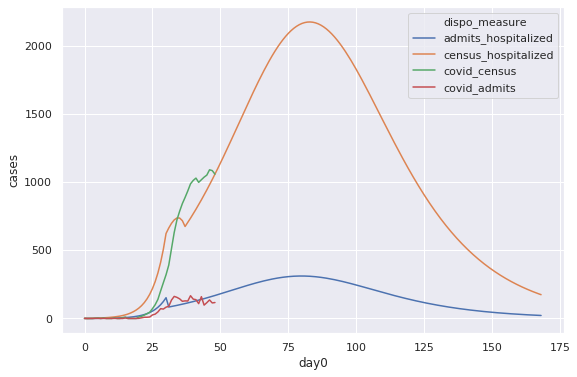

In [156]:
sns.lineplot(x='day0', y='cases', hue='dispo_measure', 
             data=hosp_data_long);

Let's look more closely at how the peaks relate.

In [157]:
x = np.array(hosp_data_wide.day0)
y_admits = np.array(hosp_data_wide.admits_hospitalized)
y_census = np.array(hosp_data_wide.census_hospitalized)
admit_peak = np.argmax(y_admits) + np.min(x)
census_peak = np.argmax(y_census) + np.min(x)
lag_txt = "Census lag = {} days".format(census_peak - admit_peak)

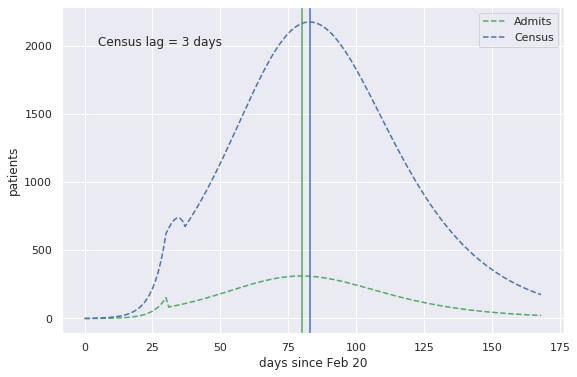

In [158]:
plt.plot(x, y_admits, 'g--', label="Admits")
plt.plot(x, y_census, 'b--', label="Census")
plt.xlabel('days since Feb 20')
plt.ylabel('patients')
plt.axvline(admit_peak, color = 'g')
plt.axvline(census_peak, color = 'b')
plt.text(5,2000, lag_txt)
plt.legend()
plt.show()

Zoom.

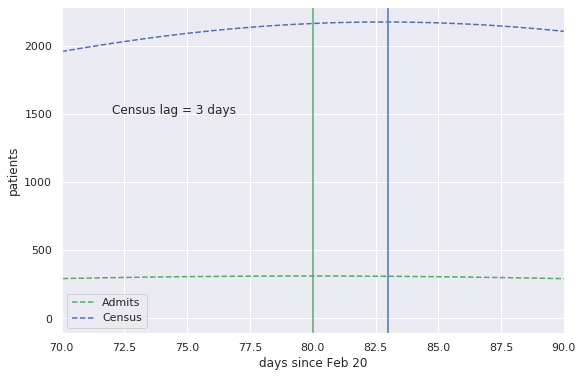

In [159]:
plt.plot(x, y_admits, 'g--', label="Admits")
plt.plot(x, y_census, 'b--', label="Census")
plt.xlabel('days since Feb 20')
plt.ylabel('patients')
plt.xlim(70, 90)
plt.axvline(admit_peak, color = 'g')
plt.axvline(census_peak, color = 'b')
plt.text(72, 1500, lag_txt)
plt.legend()
plt.show()

## Plan of attack for stochastic census model
For $M_t/G/\infty$ queueing models, there are really nice computational formulas for computing the mean value function, $m(t)$, which gives the mean of the Poisson distribution of occupancy at each time $t$. 

See 

* Eick, Stephen G., William A. Massey, and Ward Whitt. "The physics of the Mt/G/∞ queue." Operations Research 41, no. 4 (1993): 731-742.
* Jennings, Otis B., Avishai Mandelbaum, William A. Massey, and Ward Whitt. "Server staffing to meet time-varying demand." Management Science 42, no. 10 (1996): 1383-1394.

In order to use these results, we need do a few things:

* fit some sort of arrival rate function $\lambda(t)$ to the projected admit time series
* decide on length of stay distribution to use for $G$.
* do the above two things wisely so that the math and computing isn't too terrible.

### Arrival rate plan

From looking at the admit plots above and knowing what we know about SIR models, I'm going to try to fit two logistic functions, one for the growth phase and one for the decay phase. We'll see how they fit together and, if needed, shim them with a quadratic or cubic polynomial. These should be not too bad to work with in the queueing model.

### Service time (LOS) distribution plan

I'll start like all queueing analyses do, assume exponential service time distributions 🙂. Ideally, I'll have some real LOS data soon and can fit some sort of reasonable distribution to the, likely right-skewed, empirical distribution. My other thought is to use a hyperexponential distribution with three parallel stages representing three different patient types - patients with no ICU stay, patients who stay in ICU but no vent, and vent patients. 

## Fit logistic functions to admits
Piece two logistic together - one that's growth and one that's decay. Then we'll shim them if needed. Start by just exploring a logistic growth model for the first part of the projected admit data.

In [160]:
# Function to fit
# def logistic_func_1(x, a, b, c):
#      return a /(1 + b * c ** -x)

# Alternative parameterization - more fitting for epi modeling
def logistic_func(t, L, k, t0):
     return L /(1 + np.exp(-(k*(t - t0))))

Let's just throw some reasonable values in and plot.

In [161]:
(L, k, t0) = (320.0, 0.05, 45.0)

In [162]:
t = np.array(hosp_data_wide.day0)
y = np.array(logistic_func(t, L, k, t0))

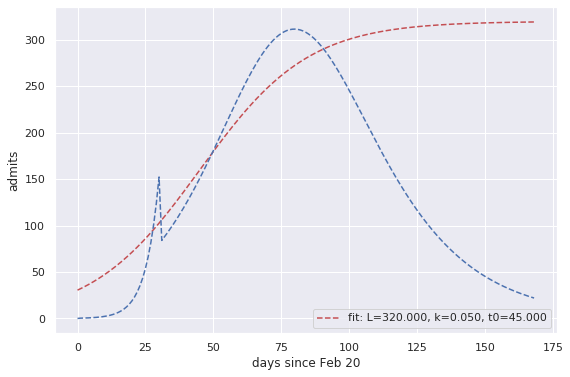

In [163]:

plt.plot(t, y, 'r--',
         label='fit: L={:5.3f}, k={:5.3f}, t0={:5.3f}'.format(L, k, t0))
plt.plot(t, y_admits, 'b--')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.show()

Ok, let's try to find a good fit from time 0 up until the peak and then fit a second logistic model for the peak and beyond.

In [164]:
# Find peaks and separate arrays into two pieces
x_peak = np.argmax(y_admits) + np.min(x)
admits_peak = np.max(y_admits) + np.min(x)
x_growth = x[:x_peak + 1]
x_decay = x[x_peak + 1:]
y_act_growth = y_admits[:x_peak + 1]
y_act_decay = y_admits[x_peak + 1:]

# Initial guesses for parameter values
(L0_growth, k0_growth, t00_growth) = (320.0, 0.08, 45.0)
(L0_decay, k0_decay, t00_decay) = (320, -0.08, 115)

Fit a logistic growth model.

In [165]:
popt_growth, pcov_growth = curve_fit(logistic_func, x_growth, y_act_growth,  p0=(L0_growth, k0_growth, t00_growth))
print(popt_growth)
y_fit_growth = logistic_func(x_growth, *popt_growth)

[3.38904351e+02 7.71987832e-02 4.72524131e+01]


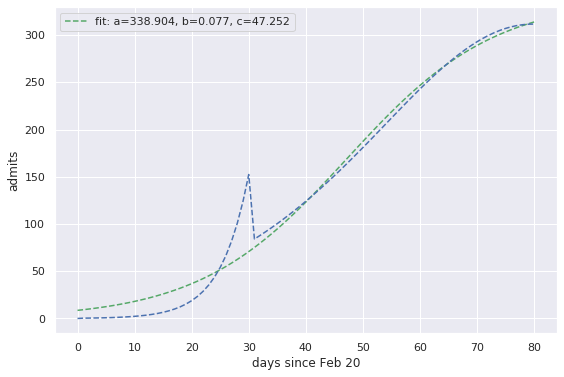

In [166]:
plt.plot(x_growth, y_fit_growth, 'g--',
         label='fit: a={:5.3f}, b={:5.3f}, c={:5.3f}'.format(*popt_growth))
plt.plot(x_growth, y_act_growth, 'b--')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.show()

Now fit the decay side in a similar way.

In [167]:
popt_decay, pcov_decay = curve_fit(logistic_func, x_decay, y_act_decay,  p0=(L0_decay, k0_decay, t00_decay))
print(popt_decay)
y_fit_decay = logistic_func(x_decay, *popt_decay)

[ 4.10764931e+02 -4.99844178e-02  1.07160965e+02]


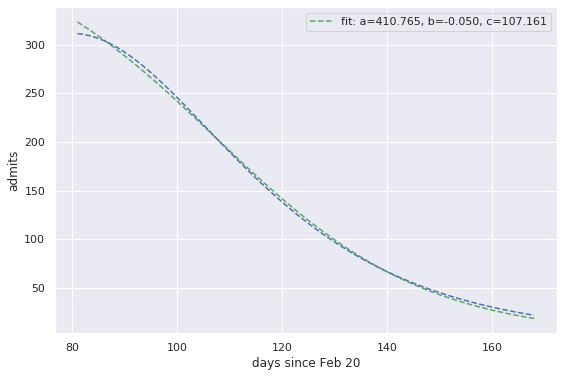

In [168]:
plt.plot(x_decay, y_fit_decay, 'g--',
         label='fit: a={:5.3f}, b={:5.3f}, c={:5.3f}'.format(*popt_decay))
plt.plot(x_decay, y_act_decay, 'b--')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.show()

Let's join the two pieces together and check the overall fit, especially near the peak where the two logistic functions are duct taped together.

In [169]:
# Join the pieces
y_fit = np.concatenate((y_fit_growth, y_fit_decay), axis=None)
x_fit_peak = np.argmax(y_fit)
admits_fit_peak = np.max(y_fit)

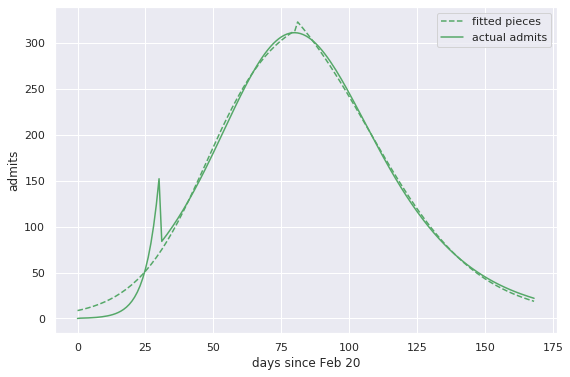

In [170]:
plt.plot(x, y_fit, 'g--',
         label='fitted pieces')
plt.plot(x, y_admits, 'g',
         label='actual admits')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.show()

Zoom in on the peak.

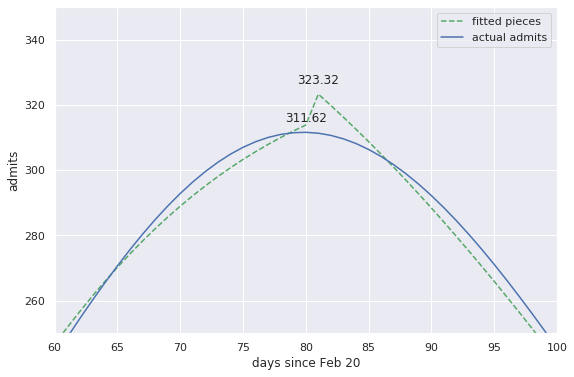

In [171]:
plt.plot(x, y_fit, 'g--',
         label='fitted pieces')
plt.plot(x, y_admits, 'b',
         label='actual admits')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.xlim(60, 100)
plt.ylim(250, 350)
label_fitted = "{:.2f}".format(admits_fit_peak)
label_admits = "{:.2f}".format(admits_peak)
plt.annotate(label_fitted, # this is the text
                 (x_fit_peak, admits_fit_peak), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.annotate(label_admits, # this is the text
                 (x_peak, admits_peak), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.legend()
plt.show()

Maybe we can improve this by perhaps using a naive shim to match the hump between, say, x=78 and x=87. 

In [173]:
shimx_lower = 78
shimx_upper = 87
x_shim = x[shimx_lower:shimx_upper + 1]
y_shim = y_admits[shimx_lower:shimx_upper + 1]

I'm going to try a quadratic as it looks sufficient to match the hump.

In [174]:
quad_shim = np.polyfit(x_shim, y_shim, 2)

In [175]:
quad_shim

array([-1.90608093e-01,  3.04115453e+01, -9.01435050e+02])

In [176]:
# Function to fit
def quad_func(x, a, b, c):
     return a * x **2 + b * x + c

In [177]:
y_fit_shim = quad_func(x_shim, *quad_shim)
y_fit_shim

array([311.00584787, 311.49192259, 311.59678113, 311.32042349,
       310.66284965, 309.62405963, 308.20405343, 306.40283104,
       304.22039246, 301.6567377 ])

In [178]:
y_fit_w_shim = np.concatenate((y_fit_growth[:shimx_lower], y_fit_shim, y_fit_decay[shimx_upper - x_peak:]), axis=None)

In [179]:
# Check for shape consistency (e.g. no off by one errors)
assert y_fit_w_shim.shape == x.shape

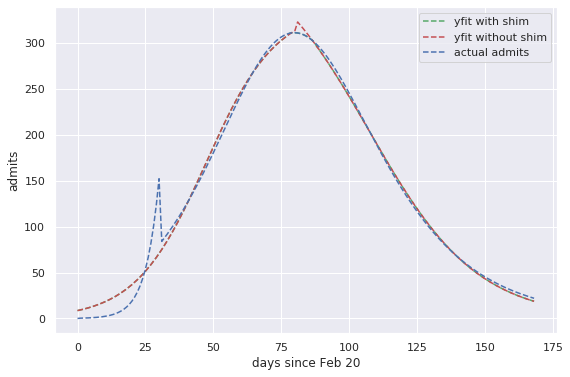

In [180]:
plt.plot(x, y_fit_w_shim, 'g--', label='yfit with shim')
plt.plot(x, y_fit, 'r--', label='yfit without shim')
plt.plot(x, y_admits, 'b--', label='actual admits')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.show()

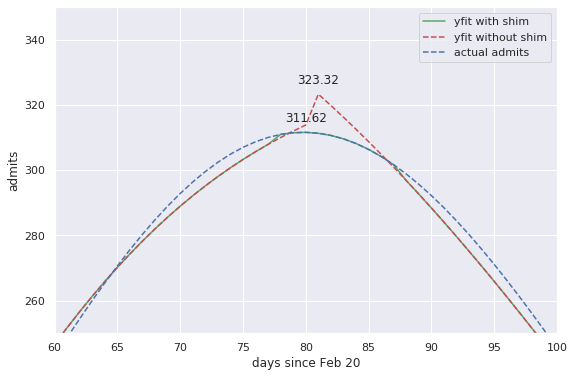

In [181]:
plt.plot(x, y_fit_w_shim, 'g-', label='yfit with shim')
plt.plot(x, y_fit, 'r--', label='yfit without shim')
plt.plot(x, y_admits, 'b--', label='actual admits')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.xlim(60, 100)
plt.ylim(250, 350)
label_fitted = "{:.2f}".format(admits_fit_peak)
label_admits = "{:.2f}".format(admits_peak)
plt.annotate(label_fitted, # this is the text
                 (x_fit_peak, admits_fit_peak), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.annotate(label_admits, # this is the text
                 (x_peak, admits_peak), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.legend()
plt.show()

Nice.

Let's create a function to represent this three-piece arrival rate function. Arrival rate related parameters always use the Greek letter $\lambda$ (see any queueing text) and I must do the same even though this has nothing to do with a Python *lambda function* and could be a source of confusion.

In [182]:
def admit_lambda(t, t1=0, t2=0, L0_g=0, k0_g=0, t0_g=0,
                L0_d=0, k0_d=0, t0_d=0,
                a=0, b=0, c=0):
    
    if t<=0:
        return 0
    elif 0 < t <= t1:
        return logistic_func(t, L0_g, k0_g, t0_g)
    elif t1 < t <= t2:
        return quad_func(t, a, b, c)
    else:
        return logistic_func(t, L0_d, k0_d, t0_d)
        

In [183]:
print(popt_growth)
print(popt_decay)
print(quad_shim)

[3.38904351e+02 7.71987832e-02 4.72524131e+01]
[ 4.10764931e+02 -4.99844178e-02  1.07160965e+02]
[-1.90608093e-01  3.04115453e+01 -9.01435050e+02]


In [184]:
admit_lambda(180,shimx_lower, shimx_upper, *popt_growth, *popt_decay, *quad_shim)

10.499331192620735

In [185]:
a, b, c = quad_shim

In [186]:
print(a, b, c)

-0.1906080930692023 30.41154533732478 -901.4350502112261


## Service time distribution parameters

First let's compute implied ALOS values for subpopulations of the model:

* patients who do not use an ICU bed
* ICU patients who do not use a vent

This is more just for information feedback to make sure ALOS inputs we are using are reasonable.

In [187]:
vars(p)

{'current_date': datetime.date(2020, 4, 8),
 'current_hospitalized': 1059,
 'date_first_hospitalized': datetime.date(2020, 2, 20),
 'doubling_time': 3.26780508121616,
 'hospitalized': Disposition(days=7, rate=0.025),
 'icu': Disposition(days=9, rate=0.0075),
 'infectious_days': 10,
 'market_share': 0.32,
 'max_y_axis': None,
 'mitigation_date': datetime.date(2020, 3, 21),
 'n_days': 120,
 'population': 5026226,
 'region': None,
 'relative_contact_rate': 0.55,
 'recovered': 0,
 'ventilated': Disposition(days=10, rate=0.005),
 'labels': {'hospitalized': 'Hospitalized',
  'icu': 'ICU',
  'ventilated': 'Ventilated',
  'day': 'Day',
  'date': 'Date',
  'susceptible': 'Susceptible',
  'infected': 'Infected',
  'recovered': 'Recovered'},
 'dispositions': {'hospitalized': Disposition(days=7, rate=0.025),
  'icu': Disposition(days=9, rate=0.0075),
  'ventilated': Disposition(days=10, rate=0.005)}}

In [188]:
hosp_los = p.hospitalized.days
hosp_pct = p.hospitalized.rate
icu_los = p.icu.days
vent_los = p.ventilated.days
icu_pct = p.icu.rate
vent_pct = p.ventilated.rate

## Implied ALOS values

Let's start by computing implied ALOS for non-vent ICU, $C^{*}$ and non-ICU hospital, $H^{*}$

In [189]:
pct_icu_w_vent = vent_pct / icu_pct
print("Proportion of icu patients requiring vent: {0:.3f}".format(pct_icu_w_vent))
icu_los_star = (icu_los - pct_icu_w_vent * vent_los) / (1.0 - pct_icu_w_vent)
print("ALOS for icu patients NOT requiring vent: {0:.1f}".format(icu_los_star))

Proportion of icu patients requiring vent: 0.667
ALOS for icu patients NOT requiring vent: 7.0


In [190]:
pct_hosp_w_icu = icu_pct / hosp_pct
print("Proportion of hospitalized patients requiring ICU: {0:.3f}".format(pct_hosp_w_icu))
hosp_los_star = (hosp_los - pct_hosp_w_icu * icu_los) / (1.0 - pct_hosp_w_icu)
print("ALOS for hospitalized patients NOT requiring ICU: {0:.1f}".format(hosp_los_star))

Proportion of hospitalized patients requiring ICU: 0.300
ALOS for hospitalized patients NOT requiring ICU: 6.1


## Simple one patient type models

Let's start with independent models for hospital beds, ICU beds, and vents. Just doing hospital beds in this notebook. 
### Exponential service times

If $S$ is our service time random variable with cdf $G(t) = P(S \leq t)$, then for exponentially distributed $S$, we have

$$
G(t) = P(S \leq t) = 1 - e^{-\mu t}
$$

where $\mu$ is the service rate. In our context, $\mu$ is the reciprocal of ALOS. We'll denote the ALOS for hospital patients by $\bar{S}$, and note that $E[S] = \bar{S}$.

For $M_t/G/\infty$ systems, an important role in computing $m(t)$ is played by the *stationary excess distribution*, $S_e$, of the service time random variable, $S$. This is also called the *residual life*. Denote the cdf of $S_e$ by $G_e$. Then (this is Equation 1 in [Eick, 1993b]),

$$
G_e(t) = P(S_e \leq t) = \frac{1}{E[S]} \int_{0}^{t} G^{c}(u)du, t \geq 0,
$$

where $G^{c}(t) = 1 - G(t)$.

The key result, which dates back to the mid-20th century (based on work by Palm and Khintchine), is that the census in this system at each time point, $t$, is Poisson distributed with mean

$$
m(t) = \int_{0}^{\inf} G^{c}(u)\lambda(t-u)du
$$

Another representation for the RHS above shows the intuitive result that the expected census is an accumulation of arrivals over a random service time before time $t$. In CHIME, this is analogous to the `cumsum` of admits over a fixed length of stay value (i.e. the user input for hospital length of stay). Of course, in CHIME, the service time is treated as a deterministic (non-random) variable.

$$
m(t) = E\left[\int_{t-S}^{t} \lambda(u)du\right] = E[\lambda(t-S_e)]E[S]
$$

Due to the memoryless property of the exponential distribution, the stationary excess distribution in a $M_t/M/\infty$ system is just the same exponential distribution. When we model length of stay with other, non-exponential distributions, this will not be the case. 



## Estimation of $m(t)$ for exponential length of stay distribution
Need to derive $m(t)$ for our piecewise logistic (with a quadratic shim) arrival rate model. For exponentially distributed length of stay, the equation,

$$
m(t) = \int_{0}^{\infty} G^{c}(u)\lambda(t-u)du
$$

becomes

$$
m(t) = \int_{0}^{t} e^{\mu s}\lambda(t-s)ds
$$

This should an easy integral to numerically integrate. Note that the `scipy.stats` function `sf`, or *survival function* is just the complement of the `cdf`, and is the $e^{\mu s}$ term in the integral we need to evaluate.

Create an exponential random variable using `scipy.stats`.

In [191]:
rv_hosp = expon(scale = hosp_los)

In [192]:
rv_hosp.expect()

7.000000000000001

In [193]:
print(rv_hosp.cdf(5))
print(rv_hosp.sf(5))

0.5104583404430469
0.4895416595569531


From the [functools](https://docs.python.org/3/library/functools.html) module, we'll create a *partially frozen* version of our arrival rate function since we are only integrating over a single variable, $t$ (time).

In [194]:
lam_hosp = partial(admit_lambda, t1=shimx_lower, t2=shimx_upper, L0_g=L0_growth, k0_g=k0_growth, t0_g=t00_growth,
                L0_d=L0_decay, k0_d=k0_decay, t0_d=t00_decay,
                a=a, b=b, c=c)

Create a function for the integrand that uses our new partially frozen arrival rate function and the survival function for the service time distribution.

In [195]:
def mv_t_hosp_integrand(u, t, lam_hosp, los_rv):
    return los_rv.sf(u) * lam_hosp(t - u)

Create a function that uses the `scipy.integrate.quad` function to do the numerical integration.

In [196]:
def mv_t_hosp(t, lam_hosp, los_rv):
    I = quad(mv_t_hosp_integrand, 0, t, args=(t, lam_hosp, los_rv))
    return I

Sanity a check a few values. Notice that the `quad` function returns the value of the integral and an error estimate.

In [197]:
mv_t_hosp(30, lam_hosp, rv_hosp)

(354.4079388133839, 3.934718537805625e-12)

In [198]:
mv_t_hosp(80, lam_hosp, rv_hosp)

(2017.339215188757, 5.874485395906959e-07)

In [199]:
mv_t_hosp(150, lam_hosp, rv_hosp)

(242.08614040710657, 1.9619167801465665e-06)

So, the following list, is the **mean** of the Poisson distribution of census at each time point, $t$. This is the computational bottleneck.

In [200]:
# Here's our set of Poisson means
y_mv = np.array([mv_t_hosp(t, lam_hosp, rv_hosp)[0] for t in hosp_data_wide.day0])
y_mv

array([   0.        ,    8.25542842,   16.07886378,   23.57990943,
         30.85734758,   38.00080283,   45.09218898,   52.20696644,
         59.41523373,   66.78267275,   74.37136467,   82.24049066,
         90.44692888,   99.04575763,  108.09067221,  117.6343217 ,
        127.72857035,  138.42468717,  149.773466  ,  161.82527793,
        174.63005695,  188.23721945,  202.69551787,  218.05282912,
        234.35587809,  251.64989775,  269.97822763,  289.38185375,
        309.89889444,  331.56403783,  354.40793881,  378.45658506,
        403.73064371,  430.24480241,  458.00712013,  487.01840517,
        517.27163857,  548.75146253,  581.43375311,  615.28529629,
        650.26358496,  686.31675227,  723.38365378,  761.394107  ,
        800.26929254,  839.92231617,  880.25892587,  921.17837292,
        962.57440092, 1004.33634248, 1046.3502994 , 1088.50037971,
       1130.66996284, 1172.74296417, 1214.60507038, 1256.14491901,
       1297.25519798, 1337.83364451, 1377.78392658, 1417.01639

In [203]:
x = np.array(hosp_data_wide.day0)
y_admits = np.array(hosp_data_wide.admits_hospitalized)
y_lambda = np.array([lam_hosp(t) for t in hosp_data_wide.day0])
y_census = np.array(hosp_data_wide.census_hospitalized)
# Here's our set of Poisson means (already computed above)
#y_mv = np.array([mv_t_hosp(t, lam_hosp, rv_hosp)[0] for t in hosp_data_wide.day0])
# Include the peak lines for fun
admit_peak = np.argmax(y_admits) + np.min(x)
census_peak = np.argmax(y_census) + np.min(x)
mv_peak = np.argmax(y_mv) + np.min(x)
lag1_txt = "CHIME census - admit lag = {} days".format(census_peak - admit_peak)
lag2_txt = "NHPP census - admit lag = {} days".format(mv_peak - admit_peak)
diff_txt = "NHPP census - CHIME census lag = {} days".format(mv_peak - census_peak)

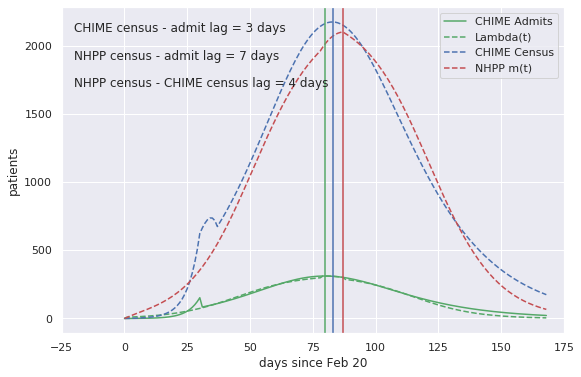

In [204]:
plt.plot(x, y_admits, 'g-', label="CHIME Admits")
plt.plot(x, y_lambda, 'g--', label="Lambda(t)")
plt.plot(x, y_census, 'b--', label="CHIME Census")
plt.plot(x, y_mv, 'r--', label="NHPP m(t)")
plt.xlabel('days since Feb 20')
plt.ylabel('patients')
plt.axvline(admit_peak, color = 'g')
plt.axvline(census_peak, color = 'b')
plt.axvline(mv_peak, color = 'r')
plt.xlim(-25, 175)
plt.text(-20,2100, lag1_txt)
plt.text(-20,1900, lag2_txt)
plt.text(-20,1700, diff_txt)
plt.legend()
plt.show()

Notice how the deterministic lag differs from the lag one gets using the stochastic model. And, the lag with the stochastic model is equal to the ALOS. Also, the peak is lower, hmm, have to think that through a little bit to make sure it is consistent with the underlying queueing theory.

## Adding percentile bands
Since the census at time $t$, let's call it $Q(t)$, is Poisson distributed with mean $m(t$), we can easily compute upper and lower percentiles of interest. Note that these percentiles **are NOT confidence limits around the mean census**. They are percentiles of the entire distribution of census.Their use in capacity planning for hospitals and call centers has a long history. See for example:

* Green, Linda. "Queueing analysis in healthcare." In Patient flow: reducing delay in healthcare delivery, pp. 281-307. Springer, Boston, MA, 2006.
* Green, Linda V., Peter J. Kolesar, and Ward Whitt. "Coping with time‐varying demand when setting staffing requirements for a service system." Production and Operations Management 16, no. 1 (2007): 13-39.

For values of $m(t)$ less than, say, 50, we'll compute the percentiles using the Poisson distribution. For larger values we'll use the normal approximation to the Poisson distribution..

In [205]:
def census_pctile(mean, p):
    if mean < 50:
        return poisson.ppf(p, mean)
    else:
        return norm.ppf(p, mean, np.sqrt(mean))

In [206]:
census_pctile(100, .95)

116.44853626951472

Let's create two new series for the 5th and 95th percentiles of census and add them to the plot.

In [207]:
y_p05 = np.array([census_pctile(m, 0.05) for m in y_mv])
y_p95 = np.array([census_pctile(m, 0.95) for m in y_mv])

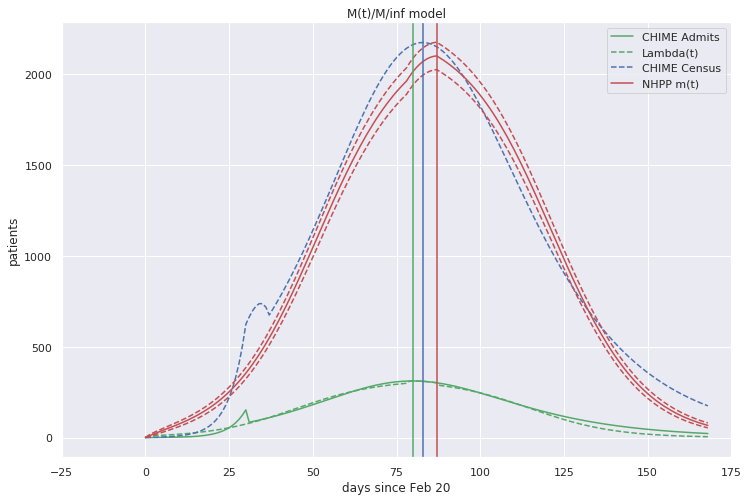

In [208]:
plt.figure(figsize=(12,8))
plt.title("M(t)/M/inf model")
plt.plot(x, y_admits, 'g-', label="CHIME Admits")
plt.plot(x, y_lambda, 'g--', label="Lambda(t)")
plt.plot(x, y_census, 'b--', label="CHIME Census")
plt.plot(x, y_mv, 'r-', label="NHPP m(t)")
plt.plot(x, y_p05, 'r--')
plt.plot(x, y_p95, 'r--')
plt.xlabel('days since Feb 20')
plt.ylabel('patients')
plt.axvline(admit_peak, color = 'g')
plt.axvline(census_peak, color = 'b')
plt.axvline(mv_peak, color = 'r')
plt.xlim(-25, 175)
# plt.text(-20,2100, lag1_txt)
# plt.text(-20,1900, lag2_txt)
# plt.text(-20,1700, diff_txt)
plt.legend()
plt.show()

## Non-exponential service time distributions
Real length of stay distributions are often right skewed. Let's redo the above example but use a gamma distribution with the same mean and the other parameters chosen to give a coefficient of variation of 0.5 (half as variable as exponential). This is actually an erlang(4) (sum of four independent exponentials).

In [209]:
rv_hosp_erlang = gamma(a=4, scale=hosp_los / 4)

In [210]:
rv_hosp_erlang.expect()

7.000000000000001

Let's see what it looks like.

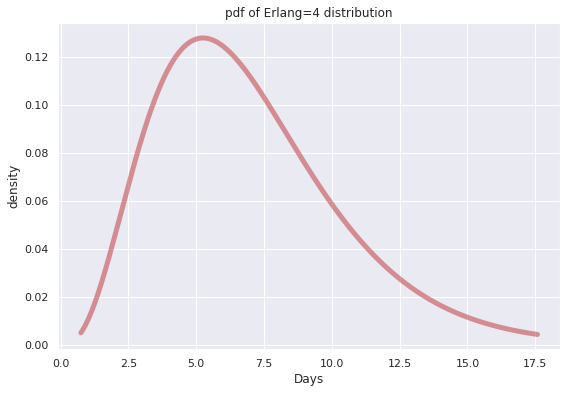

In [211]:
x_erlang = np.linspace(rv_hosp_erlang.ppf(0.001),
                rv_hosp_erlang.ppf(0.99), 500)
plt.title("pdf of Erlang=4 distribution")
plt.xlabel("Days")
plt.ylabel("density")
plt.plot(x_erlang, rv_hosp_erlang.pdf(x_erlang),
       'r-', lw=5, alpha=0.6, label='erlang-4 pdf');


In [212]:
mv_t_hosp(30, lam_hosp, rv_hosp_erlang)

(399.62311975986916, 2.278005811762185e-09)

In [213]:
mv_t_hosp(80, lam_hosp, rv_hosp_erlang)

(2078.916860347081, 3.308900886622723e-07)

In [214]:
# Here's our new set of Poisson means for erlang LOS distribution
y_mv_erlang = np.array([mv_t_hosp(t, lam_hosp, rv_hosp_erlang)[0] for t in hosp_data_wide.day0])

In [215]:
y_p05_erlang = np.array([census_pctile(m, 0.05) for m in y_mv_erlang])
y_p95_erlang = np.array([census_pctile(m, 0.95) for m in y_mv_erlang])

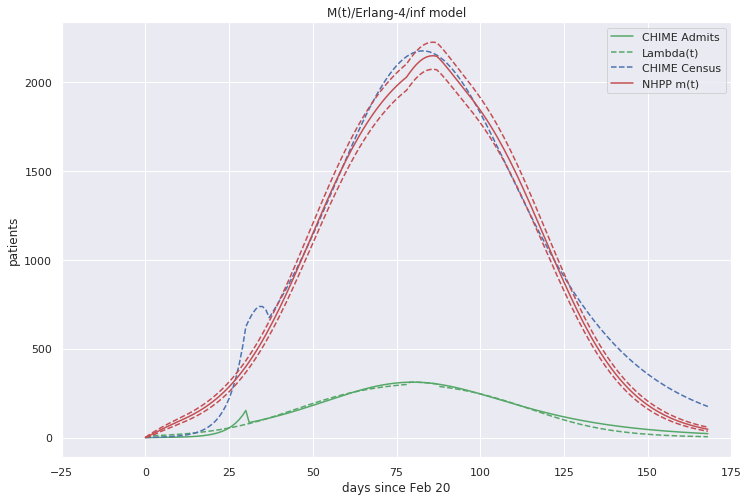

In [216]:
plt.figure(figsize=(12,8))
plt.title("M(t)/Erlang-4/inf model")
plt.plot(x, y_admits, 'g-', label="CHIME Admits")
plt.plot(x, y_lambda, 'g--', label="Lambda(t)")
plt.plot(x, y_census, 'b--', label="CHIME Census")
plt.plot(x, y_mv_erlang, 'r-', label="NHPP m(t)")
plt.plot(x, y_p05_erlang, 'r--')
plt.plot(x, y_p95_erlang, 'r--')
plt.xlabel('days since Feb 20')
plt.ylabel('patients')
# plt.axvline(admit_peak, color = 'g')
# plt.axvline(census_peak, color = 'b')
# plt.axvline(mv_peak, color = 'r')
plt.xlim(-25, 175)
# plt.text(-20,2100, lag1_txt)
# plt.text(-20,1900, lag2_txt)
# plt.text(-20,1700, diff_txt)
plt.legend()
plt.show()

## Next Steps
Looks promising as a way to capture stochastic process related uncertainty such as fact that length of stay is not deterministic in real world. Next, will do:

* share for review by others,
* generalize and automate the arrival rate fitting part,
* test for more LOS distributions and check for consistency with underlying queueing theory,
* figure out way to implement this so that it's not a computational bottleneck (could always be a post-processor),
* think about how this could be combined with Bayesian approach to parameter uncertainty.

<font size="2">This material is made available under the [MIT License](https://opensource.org/licenses/MIT).</font>